# NLP with GloVe embeddings

## Set-up

In [2]:
import os
import itertools
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import xavier_uniform_
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
os.chdir('..')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stevengeorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Need to specify device so that code can easily run on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load training and dev data

In [6]:
train = pd.read_parquet('data/processed/train.parquet')
print(train.shape)

dev = pd.read_parquet('data/processed/dev.parquet')
print(dev.shape)

(749640, 13)
(92689, 13)


In [7]:
train.head()

,id_odsp,sort_order,time,text,event_type,event_team,opponent,is_goal,assist_method,fast_break,season,country,event_team_was_home
0,UFot0hit/,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Hamburg SV,Borussia Dortmund,0,Pass,0,2012,germany,0
1,UFot0hit/,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
2,UFot0hit/,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
3,UFot0hit/,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
4,UFot0hit/,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,Hamburg SV,Borussia Dortmund,0,None,0,2012,germany,0


- Remove `time` and `event_team_was_home` for now but may want to add these back as they are not extracted from the text itself

In [8]:
def process_data_for_nlp(df):
    
    df = df.copy()
    
    # Sort by event order
    df.sort_values(['id_odsp', 'sort_order'], inplace=True)
    # Create target
    df['next_event_is_goal'] = df.groupby('id_odsp')['is_goal'].shift(-1)
    # Drop redundant columns
    df.drop(
        columns=['sort_order', 'event_type', 'event_team', 'opponent', 'is_goal', 'assist_method', 'fast_break', 'season', 'country', 'event_team_was_home', 'time'], 
        inplace=True
    )
    # Drop entries with null target due to -1 shift
    df.dropna(subset=['next_event_is_goal'], axis=0, inplace=True)
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [9]:
train_p = process_data_for_nlp(train)
dev_p = process_data_for_nlp(dev)

In [10]:
train_p.head()

,id_odsp,text,next_event_is_goal
0,004f4ING/,Bafetimbi Gomis (Swansea City) wins a free kic...,0.0
1,004f4ING/,Foul by Maya Yoshida (Southampton).,0.0
2,004f4ING/,Dusan Tadic (Southampton) wins a free kick on ...,0.0
3,004f4ING/,Foul by Neil Taylor (Swansea City).,0.0
4,004f4ING/,Attempt saved. James Ward-Prowse (Southampton)...,0.0


In [11]:
dev_p.head()

,id_odsp,text,next_event_is_goal
0,00nmICd9/,Foul by Juan Manuel FalcA³n (Metz).,0.0
1,00nmICd9/,TiemouA© Bakayoko (Monaco) wins a free kick in...,0.0
2,00nmICd9/,Foul by Anthony Martial (Monaco).,0.0
3,00nmICd9/,Sylvain Marchal (Metz) wins a free kick in the...,0.0
4,00nmICd9/,Foul by Cheick Doukoure (Metz).,0.0


## Tokenize text commentary

GloVe we are using is uncased so change all text to lower case:

In [12]:
def tokenize_text_commentary(df):
    df['text_lowercase'] = df['text'].str.lower()  # GloVe is lowercase
    df['text_split'] = df['text_lowercase'].apply(lambda x: word_tokenize(x))

In [13]:
%%time
tokenize_text_commentary(train_p)

CPU times: user 1min 52s, sys: 670 ms, total: 1min 53s
Wall time: 1min 53s


In [14]:
%%time
tokenize_text_commentary(dev_p)

CPU times: user 13.3 s, sys: 66.5 ms, total: 13.4 s
Wall time: 13.4 s


In [15]:
train_p.head()

,id_odsp,text,next_event_is_goal,text_lowercase,text_split
0,004f4ING/,Bafetimbi Gomis (Swansea City) wins a free kic...,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ..."
1,004f4ING/,Foul by Maya Yoshida (Southampton).,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]"
2,004f4ING/,Dusan Tadic (Southampton) wins a free kick on ...,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre..."
3,004f4ING/,Foul by Neil Taylor (Swansea City).,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]"
4,004f4ING/,Attempt saved. James Ward-Prowse (Southampton)...,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou..."


In [16]:
dev_p.head()

,id_odsp,text,next_event_is_goal,text_lowercase,text_split
0,00nmICd9/,Foul by Juan Manuel FalcA³n (Metz).,0.0,foul by juan manuel falca³n (metz).,"[foul, by, juan, manuel, falca³n, (, metz, ), .]"
1,00nmICd9/,TiemouA© Bakayoko (Monaco) wins a free kick in...,0.0,tiemoua© bakayoko (monaco) wins a free kick in...,"[tiemoua©, bakayoko, (, monaco, ), wins, a, fr..."
2,00nmICd9/,Foul by Anthony Martial (Monaco).,0.0,foul by anthony martial (monaco).,"[foul, by, anthony, martial, (, monaco, ), .]"
3,00nmICd9/,Sylvain Marchal (Metz) wins a free kick in the...,0.0,sylvain marchal (metz) wins a free kick in the...,"[sylvain, marchal, (, metz, ), wins, a, free, ..."
4,00nmICd9/,Foul by Cheick Doukoure (Metz).,0.0,foul by cheick doukoure (metz).,"[foul, by, cheick, doukoure, (, metz, ), .]"


In [17]:
# Combine all token lists together and find set to get vocab
vocab_set = set(
    itertools.chain.from_iterable(
        list(train_p['text_split'])
    )
)

In [18]:
len(vocab_set)

6468

In [19]:
# Create token to index dict
word_to_idx = dict(
    zip(
        vocab_set, 
        range(  # Start index from 1 as we reserve the 0 index for the padding vector
            1,
            len(vocab_set)+1
        )
    )
)

In [20]:
%%time
# For each sentence in training map tokens to corresponding index
train_p['token_sequence'] = [[word_to_idx[token] for token in commentary] for commentary in list(train_p['text_split'])]

CPU times: user 2.64 s, sys: 57.5 ms, total: 2.7 s
Wall time: 2.7 s


In [21]:
train_p.head()

,id_odsp,text,next_event_is_goal,text_lowercase,text_split,token_sequence
0,004f4ING/,Bafetimbi Gomis (Swansea City) wins a free kic...,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ...","[2655, 6068, 627, 2661, 3802, 434, 5341, 2967,..."
1,004f4ING/,Foul by Maya Yoshida (Southampton).,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]","[2868, 999, 3595, 4600, 627, 3844, 434, 5118]"
2,004f4ING/,Dusan Tadic (Southampton) wins a free kick on ...,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre...","[1368, 2824, 627, 3844, 434, 5341, 2967, 1023,..."
3,004f4ING/,Foul by Neil Taylor (Swansea City).,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]","[2868, 999, 2118, 302, 627, 2661, 3802, 434, 5..."
4,004f4ING/,Attempt saved. James Ward-Prowse (Southampton)...,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou...","[1313, 3572, 5118, 3895, 3022, 627, 3844, 434,..."


In [22]:
MAX_LENGTH = np.max([len(seq) for seq in train_p['token_sequence']])  # Max length of tokens for any sentence in the training data
MAX_LENGTH

50

In [23]:
def pad_sentence(sentence_seq, max_length=MAX_LENGTH):
    """
    Takes a list of numbers representing a sentence and appends zeros to the list until `max_length` is achieved.
    """
    if len(sentence_seq) < max_length:
        num_zeros_to_add = max_length - len(sentence_seq)
        zeros_list = list(np.zeros(num_zeros_to_add))
        zeros_list = [int(x) for x in zeros_list]  # Convert zeros to int
        
        sentence_seq = sentence_seq + zeros_list
        
    return sentence_seq

In [24]:
%%time
train_p['token_sequence'] = [pad_sentence(token_sequence) for token_sequence in train_p['token_sequence']]

CPU times: user 7.51 s, sys: 132 ms, total: 7.64 s
Wall time: 7.65 s


In [25]:
# Create training array where each row has the token indices for the word in that sentence
X_train = np.array(
    list(train_p['token_sequence'])
)

X_train.shape

(742443, 50)

In [26]:
X_train

array([[2655, 6068,  627, ...,    0,    0,    0],
       [2868,  999, 3595, ...,    0,    0,    0],
       [1368, 2824,  627, ...,    0,    0,    0],
       ...,
       [3658,   66, 5681, ...,    0,    0,    0],
       [1313, 3572, 5118, ...,    0,    0,    0],
       [3658,   66, 5681, ...,    0,    0,    0]])

In [27]:
y_train = train_p['next_event_is_goal'].values
y_train.shape

(742443,)

## Prepare dev dataset

In [28]:
dev_p.head()

,id_odsp,text,next_event_is_goal,text_lowercase,text_split
0,00nmICd9/,Foul by Juan Manuel FalcA³n (Metz).,0.0,foul by juan manuel falca³n (metz).,"[foul, by, juan, manuel, falca³n, (, metz, ), .]"
1,00nmICd9/,TiemouA© Bakayoko (Monaco) wins a free kick in...,0.0,tiemoua© bakayoko (monaco) wins a free kick in...,"[tiemoua©, bakayoko, (, monaco, ), wins, a, fr..."
2,00nmICd9/,Foul by Anthony Martial (Monaco).,0.0,foul by anthony martial (monaco).,"[foul, by, anthony, martial, (, monaco, ), .]"
3,00nmICd9/,Sylvain Marchal (Metz) wins a free kick in the...,0.0,sylvain marchal (metz) wins a free kick in the...,"[sylvain, marchal, (, metz, ), wins, a, free, ..."
4,00nmICd9/,Foul by Cheick Doukoure (Metz).,0.0,foul by cheick doukoure (metz).,"[foul, by, cheick, doukoure, (, metz, ), .]"


In [29]:
# Look up each token in word_to_index (from training) and get index value or drop if not in dictionary
dev_p['token_sequence'] = [[word_to_idx.get(token) for token in commentary if word_to_idx.get(token) != None] for commentary in list(dev_p['text_split'])]

In [30]:
dev_p.head()

,id_odsp,text,next_event_is_goal,text_lowercase,text_split,token_sequence
0,00nmICd9/,Foul by Juan Manuel FalcA³n (Metz).,0.0,foul by juan manuel falca³n (metz).,"[foul, by, juan, manuel, falca³n, (, metz, ), .]","[2868, 999, 3409, 2622, 4888, 627, 3055, 434, ..."
1,00nmICd9/,TiemouA© Bakayoko (Monaco) wins a free kick in...,0.0,tiemoua© bakayoko (monaco) wins a free kick in...,"[tiemoua©, bakayoko, (, monaco, ), wins, a, fr...","[5046, 3992, 627, 38, 434, 5341, 2967, 1023, 5..."
2,00nmICd9/,Foul by Anthony Martial (Monaco).,0.0,foul by anthony martial (monaco).,"[foul, by, anthony, martial, (, monaco, ), .]","[2868, 999, 3818, 3837, 627, 38, 434, 5118]"
3,00nmICd9/,Sylvain Marchal (Metz) wins a free kick in the...,0.0,sylvain marchal (metz) wins a free kick in the...,"[sylvain, marchal, (, metz, ), wins, a, free, ...","[5393, 4698, 627, 3055, 434, 5341, 2967, 1023,..."
4,00nmICd9/,Foul by Cheick Doukoure (Metz).,0.0,foul by cheick doukoure (metz).,"[foul, by, cheick, doukoure, (, metz, ), .]","[2868, 999, 2737, 2989, 627, 3055, 434, 5118]"


In [31]:
# Trim to length
dev_p['token_sequence'] = [token_sequence[:MAX_LENGTH] for token_sequence in list(dev_p['token_sequence'])]  

In [32]:
%%time
dev_p['token_sequence'] = [pad_sentence(token_sequence) for token_sequence in dev_p['token_sequence']]

CPU times: user 884 ms, sys: 14.4 ms, total: 898 ms
Wall time: 899 ms


In [33]:
# Create dev array where each row has the token indices for the word in that sentence
X_dev = np.array(
    list(dev_p['token_sequence'])
)

X_dev.shape

(91789, 50)

In [34]:
X_dev

array([[2868,  999, 3409, ...,    0,    0,    0],
       [5046, 3992,  627, ...,    0,    0,    0],
       [2868,  999, 3818, ...,    0,    0,    0],
       ...,
       [3637, 3118,  627, ...,    0,    0,    0],
       [ 216,  644, 4195, ...,    0,    0,    0],
       [1313, 3660, 5118, ...,    0,    0,    0]])

In [35]:
y_dev = dev_p['next_event_is_goal'].values
y_dev.shape

(91789,)

## Load pre-trained GloVe embeddings

In [36]:
%%time
word_to_vector = {}
with open('data/external/GloVe/glove.6B/glove.6B.100d.txt', "r") as f:
    # Each line starts with the word/character followed by the 100d vector representation
    for line in f:
        
        # Split by whitespace:
        components = line.split()
        
        word = components[0]
        vector_values = components[1:]
        
        vector_array = np.array(vector_values, dtype=np.float64)  # Convert vector to numpy array
        
        # Add to dictionary
        word_to_vector[word] = vector_array

CPU times: user 7.61 s, sys: 289 ms, total: 7.9 s
Wall time: 7.96 s


In [37]:
len(word_to_vector.keys())

400000

In [38]:
word_to_vector['foul']

array([ 8.8509e-01, -8.0413e-01,  7.3326e-01, -1.1997e+00, -4.4433e-01,
        9.9010e-01, -1.1211e-01, -7.0893e-01, -1.4639e-01, -1.9667e-01,
       -1.4831e-01, -1.0859e-01, -3.9821e-01, -4.9383e-01,  1.0474e+00,
        6.4321e-01, -6.4378e-01, -2.7974e-01, -4.2865e-01,  5.5361e-02,
        2.1271e-01,  6.2063e-01,  1.1255e-01, -9.9549e-02,  5.2189e-01,
       -2.9921e-01, -6.3453e-01,  5.5675e-01,  1.0460e-01, -1.0456e-01,
        3.0833e-02, -1.0498e-03,  5.6656e-01, -1.1333e-01, -5.8664e-02,
       -5.9103e-01, -2.2791e-01,  3.2208e-01,  6.9484e-02,  3.6374e-01,
       -3.4399e-01,  3.3388e-02,  1.2079e-01, -6.0931e-01, -3.2988e-01,
        5.1176e-02, -3.5307e-01, -4.5887e-02, -2.0085e-01, -6.6991e-01,
        4.3831e-01,  3.8817e-01, -9.4224e-01,  5.2481e-01, -7.7710e-02,
       -1.3177e+00, -1.2479e-01,  3.3277e-01,  1.1003e+00,  4.8362e-01,
       -3.4234e-01,  1.5704e-01, -6.7879e-01,  4.4289e-01, -1.7270e-01,
       -5.3625e-01,  1.0005e+00, -9.6411e-01, -1.2487e+00, -1.94

## Create embedding matrix

In [39]:
GLOVE_DIMENSION = 100

In [40]:
# Create empty matrix for embedding matrix
embedding_matrix = np.zeros(
    (
        len(vocab_set) + 1,  # Additional 1 for zero vector for padding
        GLOVE_DIMENSION
    )
)
embedding_matrix.shape

(6469, 100)

In [41]:
len(word_to_idx.keys())

6468

In [42]:
for word, idx in word_to_idx.items():
    try:
        embedding_matrix[idx, :] = word_to_vector[word]
    except KeyError:  # Word in training set not in GloVe
        embedding_matrix[idx, :] = np.zeros(GLOVE_DIMENSION)  # We replace unknown words with zeros

In [43]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.26471  , -0.71637  , -0.45125  , ...,  0.020477 , -0.72754  ,
        -0.014638 ],
       [-0.0048263,  0.33234  ,  0.47517  , ...,  0.21186  , -1.1026   ,
        -0.80131  ],
       ...,
       [ 0.67325  ,  0.13945  ,  0.23453  , ..., -0.46699  , -0.5231   ,
        -0.037473 ],
       [-0.49159  , -0.25307  ,  0.35817  , ...,  0.40691  , -0.13232  ,
         0.44799  ],
       [-0.47665  , -0.81064  , -0.31259  , ...,  0.3136   , -1.1385   ,
         0.16221  ]])

In [44]:
np.sum(embedding_matrix.sum(axis=1) == 0)  # Number of words in vocab but not in GloVe

1885

In [45]:
# Convert to tensor for PyTorch
embedding_tensor = torch.from_numpy(embedding_matrix)
embedding_tensor = embedding_tensor.to(device)

## Create custom Dataset class

In [46]:
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

((742443, 50), (742443,), (91789, 50), (91789,))

In [47]:
class CommentaryDataset(Dataset):

    def __init__(self, X, y):
        """
        """
        self.X = X
        self.y = y.reshape(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.X[idx, :], self.y[idx, :]

In [48]:
commentary_train = CommentaryDataset(X_train, y_train)
commentary_dev = CommentaryDataset(X_dev, y_dev)

## Train model

In [210]:
class NextEventIsGoal(nn.Module):

    def __init__(self):
        super(NextEventIsGoal, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_tensor, freeze=False)
        # LSTM
        self.lstm = nn.LSTM(input_size=GLOVE_DIMENSION, hidden_size=125, batch_first=True)
        # MLP
        self.fc_1 = nn.Linear(in_features=125, out_features=125)
        self.fc_2 = nn.Linear(in_features=125, out_features=1)

        xavier_uniform_(self.fc_1.weight)  # in-place
        xavier_uniform_(self.fc_2.weight)  # in-place        
        
        self.dropout = nn.Dropout(p=0)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        
        x = x.float()
        
        all_h_t, _ = self.lstm(x)
        
        h_T = all_h_t[:, -1, :]  # Final cell outputs
        
        x = self.fc_1(h_T)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)

        x = self.sigmoid(x)
        
        return x

In [211]:
model = NextEventIsGoal()
model.to(device)

NextEventIsGoal(
  (embedding): Embedding(6469, 100)
  (lstm): LSTM(100, 125, batch_first=True)
  (fc_1): Linear(in_features=125, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [212]:
model.named_parameters

<bound method Module.named_parameters of NextEventIsGoal(
  (embedding): Embedding(6469, 100)
  (lstm): LSTM(100, 125, batch_first=True)
  (fc_1): Linear(in_features=125, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>

In [213]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
sum(p.numel() for p in model.parameters() if p.requires_grad)

776276

In [214]:
criterion = nn.BCELoss()
optimiser = optim.Adam(params=model.parameters(), lr=0.0001)

Use subset of training data otherwise takes forever...

In [215]:
len(commentary_train)

742443

In [216]:
num_subset_examples = 50000

train_ncd_subset = torch.utils.data.Subset(
    commentary_train, 
    indices=np.random.choice(
        range(len(commentary_train)), 
        num_subset_examples
    )
)

In [217]:
%%time
training_losses = []
dev_losses = []

for epoch in range(10):
    for data in DataLoader(train_ncd_subset, batch_size=256):
        
        X, y = data

        optimiser.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = model(X)
        loss = criterion(y_pred, y.float())

        loss.backward()
        optimiser.step()
    
    # Training loss
    training_loss_total = 0
    for data in DataLoader(train_ncd_subset, batch_size=256, shuffle=True):
        X_train, y_train = data
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        y_pred = model(X_train)
        
        batch_loss_sum = float(
            nn.BCELoss(reduction='sum')(y_pred, y_train.float())
        )
        training_loss_total += batch_loss_sum
    
    loss = training_loss_total / len(train_ncd_subset)
    training_losses.append(loss)
        
    # Dev loss
    dev_loss_total = 0
    for data in DataLoader(commentary_dev, batch_size=256):
        X_dev, y_dev = data
        X_dev, y_dev = X_dev.to(device), y_dev.to(device)
        
        y_pred = model(X_dev)
        
        batch_loss_sum = float(
            nn.BCELoss(reduction='sum')(y_pred, y_dev.float())
        )
        dev_loss_total += batch_loss_sum
        
    loss = dev_loss_total / len(commentary_dev)
    dev_losses.append(loss)
    
    print(f'Epoch: {epoch+1}, train_loss: {training_losses[-1]}, dev_loss: {dev_losses[-1]}')

Epoch: 1, train_loss: 0.12034122898101807, dev_loss: 0.12193901747243376
Epoch: 2, train_loss: 0.12023065900325774, dev_loss: 0.12188425774649035
Epoch: 3, train_loss: 0.12018193529605865, dev_loss: 0.12189040002042702
Epoch: 4, train_loss: 0.12010844686508179, dev_loss: 0.12188682905874833
Epoch: 5, train_loss: 0.11942042872428894, dev_loss: 0.12128456200794782
Epoch: 6, train_loss: 0.11770236152648926, dev_loss: 0.11957755254680173
Epoch: 7, train_loss: 0.11746811841964722, dev_loss: 0.119622199994004
Epoch: 8, train_loss: 0.11703162300109864, dev_loss: 0.11953444757733658
Epoch: 9, train_loss: 0.11654180830955506, dev_loss: 0.11949342284367619
Epoch: 10, train_loss: 0.11595491205215454, dev_loss: 0.11955712713266035
CPU times: user 15min 48s, sys: 7min 20s, total: 23min 8s
Wall time: 16min 23s


<Figure size 576x432 with 0 Axes>

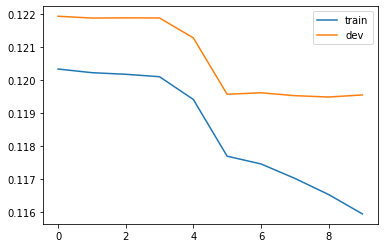

In [218]:
plt.figure(figsize=(8, 6))
pd.DataFrame({'train': training_losses, 'dev': dev_losses}).plot()
plt.show()

## Training ROCAUC

In [219]:
y_train_list = []
y_pred_list = []

for data in DataLoader(train_ncd_subset, batch_size=256):
    X_train, y_train = data
    X_train, y_train = X_train.to(device), y_train.to(device)

    y_pred = model(X_train)
    
    y_train_list.append(y_train.detach().numpy())
    y_pred_list.append(y_pred.detach().numpy())

In [220]:
y_train = np.concatenate(y_train_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [221]:
roc_auc_score(y_train, y_pred)

0.6929264388769583

## Dev ROCAUC

In [222]:
y_dev_list = []
y_pred_list = []

for data in DataLoader(commentary_dev, batch_size=256):
    X_dev, y_dev = data
    X_dev, y_dev = X_dev.to(device), y_dev.to(device)

    y_pred = model(X_dev)
    
    y_dev_list.append(y_dev.detach().numpy())
    y_pred_list.append(y_pred.detach().numpy())

In [223]:
y_dev = np.concatenate(y_dev_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [224]:
roc_auc_score(y_dev, y_pred)

0.6487184882148888

## References

https://nlp.stanford.edu/projects/glove/